Part 2 - Segmentation Model

In [ ]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv('cleaned_data')
df.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran_s_admin,veterans_benefits,weeks_worked_in_year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


Rule based segmentation

In [4]:
print(df['education'].value_counts())

education
High school graduate                      48407
Children                                  47422
Some college but no degree                27820
Bachelors degree(BA AB BS)                19865
7th and 8th grade                          8007
10th grade                                 7557
11th grade                                 6876
Masters degree(MA MS MEng MEd MSW MBA)     6541
9th grade                                  6230
Associates degree-occup /vocational        5358
Associates degree-academic program         4363
5th or 6th grade                           3277
12th grade no diploma                      2126
1st 2nd 3rd or 4th grade                   1799
Prof school degree (MD DDS DVM LLB JD)     1793
Doctorate degree(PhD EdD)                  1263
Less than 1st grade                         819
Name: count, dtype: int64


In [5]:
print(df['full_or_part_time_employment_stat'].value_counts())

full_or_part_time_employment_stat
Children or Armed Forces              123769
Full-time schedules                    40736
Not in labor force                     26808
PT for non-econ reasons usually FT      3322
Unemployed full-time                    2311
PT for econ reasons usually PT          1209
Unemployed part- time                    843
PT for econ reasons usually FT           525
Name: count, dtype: int64


In [6]:
df['age_bucket'] = pd.cut(df['age'],bins=[-np.inf, 24, 54, np.inf], labels=['young_<=24', 'working_25_54', 'older_55+'])

In [7]:
edu = df['education'].astype(str).str.strip().str.lower()

def edu_bucket_fn(s):
    if 'children' in s:
        return 'child'
    if 'bachelors' in s or 'masters' in s or 'prof school' in s or 'doctorate' in s:
        return 'bachelor_plus'
    if 'high school graduate' in s or 'some college' in s or 'associates' in s:
        return 'hs_some_college'
    return 'lt_hs'

df['edu_bucket'] = edu.apply(edu_bucket_fn)

df['edu_bucket'].value_counts()

edu_bucket
hs_some_college    85948
child              47422
lt_hs              36691
bachelor_plus      29462
Name: count, dtype: int64

In [8]:
ws = df['full_or_part_time_employment_stat'].astype(str).str.strip().str.lower()

df['work_bucket'] = np.select(
    [
        ws.str.contains('children') | ws.str.contains('armed forces'),
        ws.str.contains('full-time schedules'),
        ws.str.contains('pt '),
        ws.str.contains('unemployed'),
        ws.str.contains('not in labor force'),
    ],
    [
        'child_or_armed_forces',
        'full_time',
        'part_time',
        'unemployed',
        'not_in_labor_force',
    ],
    default='other'
)

df['work_bucket'].value_counts()

work_bucket
child_or_armed_forces    123769
full_time                 40736
not_in_labor_force        26808
part_time                  5056
unemployed                 3154
Name: count, dtype: int64

In [9]:
age_b = df['age_bucket']
edu_b = df['edu_bucket']
work_b = df['work_bucket']

conditions = [
    # S1: Youth / dependents (covers children / armed forces / most <=24)
    (age_b == 'young_<=24') &((edu_b == 'child') | (work_b == 'child_or_armed_forces')),

    # S2: Young working full-time (first-job / early career)
    (age_b == 'young_<=24') & (work_b == 'full_time') & (edu_b != 'child'),

    # S3: Young not full-time (PT, unemployed, NILF)
    (age_b == 'young_<=24') & (work_b != 'full_time') & (edu_b != 'child'),

    # S4: Working-age FT bachelor+
    (age_b == 'working_25_54') & (work_b == 'full_time') & (edu_b == 'bachelor_plus'),

    # S5: Working-age FT non-bachelor
    (age_b == 'working_25_54') & (work_b == 'full_time') & (edu_b != 'bachelor_plus'),

    # S6: Working-age not full-time
    (age_b == 'working_25_54') & (work_b != 'full_time'),

    # S7: Older working (FT or PT)
    (age_b == 'older_55+') & (work_b.isin(['full_time', 'part_time'])),

    # S8: Older not working (unemployed or NILF)
    (age_b == 'older_55+') & (~work_b.isin(['full_time', 'part_time'])),
]

segment_names = [
    'S1 Youth / dependents',
    'S2 Young FT workers',
    'S3 Young not FT',
    'S4 Prime-age FT bachelor+',
    'S5 Prime-age FT non-bachelor',
    'S6 Prime-age not FT',
    'S7 Older working',
    'S8 Older not working',
]

df['segment_rule'] = np.select(conditions, segment_names, default='S0 Other / edge')

df['segment_rule'].value_counts()

segment_rule
S1 Youth / dependents           60698
S6 Prime-age not FT             55740
S8 Older not working            34363
S5 Prime-age FT non-bachelor    20929
S4 Prime-age FT bachelor+        8839
S3 Young not FT                  7243
S2 Young FT workers              5875
S7 Older working                 5836
Name: count, dtype: int64

ML model for clustering

In [10]:
print(df['segment_rule'].value_counts())

segment_rule
S1 Youth / dependents           60698
S6 Prime-age not FT             55740
S8 Older not working            34363
S5 Prime-age FT non-bachelor    20929
S4 Prime-age FT bachelor+        8839
S3 Young not FT                  7243
S2 Young FT workers              5875
S7 Older working                 5836
Name: count, dtype: int64


In [ ]:
# drop the column we do not need
drop_cols = [c for c in df.columns if c in ['label', 'weight', 'year'] or c.startswith('segment_')]
X_seg = df.drop(columns=drop_cols, errors='ignore')
w_seg = df['weight'].astype(float)


numerical_col = X_seg.select_dtypes(include=[np.number]).columns.tolist()
categorical_col = [c for c in X_seg.columns if c not in numerical_col]

print('Clustering features:', X_seg.shape)
print('# numeric:', len(numerical_col), '| # categorical:', len(categorical_col))

numerical_tran = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

cate_tran = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=50, sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numerical_tran, numerical_col),
        ('cat', cate_tran, categorical_col),
    ],
    remainder='drop'
)


svd = TruncatedSVD(n_components=50, random_state=42)


X_enc = preprocess.fit_transform(X_seg)
X_red = svd.fit_transform(X_enc)

print('Encoded shape:', X_enc.shape, '| Reduced shape:', X_red.shape)


rows = []
for k in range(4, 13):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_red)

    sil = silhouette_score(X_red, labels, sample_size=10000, random_state=42)
    inertia = km.inertia_

    # weighted cluster size diagnostics (important for business usability)
    clust_weight = pd.Series(w_seg.values).groupby(labels).sum()
    pct = (clust_weight / clust_weight.sum()).sort_values(ascending=False)

    rows.append({
        'k': k,
        'silhouette': sil,
        'inertia': inertia,
        'largest_cluster_pct': float(pct.iloc[0]),
        'smallest_cluster_pct': float(pct.iloc[-1]),
    })

k_table = pd.DataFrame(rows).sort_values('silhouette', ascending=False)
k_table['largest_cluster_pct'] = (k_table['largest_cluster_pct'] * 100).round(2)
k_table['smallest_cluster_pct'] = (k_table['smallest_cluster_pct'] * 100).round(2)
k_table['silhouette'] = k_table['silhouette'].round(4)

k_table


Clustering features: (199523, 42)
# numeric: 11 | # categorical: 31
Encoded shape: (199523, 405) | Reduced shape: (199523, 50)


,k,silhouette,inertia,largest_cluster_pct,smallest_cluster_pct
0,4,0.2399,2.914950e+06,25.72,23.29
1,5,0.2350,2.750922e+06,25.57,13.01
8,12,0.2269,2.206808e+06,20.13,1.97
7,11,0.2269,2.248863e+06,20.62,2.17
4,8,0.2255,2.427722e+06,20.92,2.18
3,7,0.2195,2.599598e+06,23.67,3.28
2,6,0.2136,2.718725e+06,25.57,3.30
5,9,0.2131,2.387175e+06,20.92,2.17
6,10,0.2110,2.349219e+06,20.92,2.17


In [12]:
print(k_table)

    k  silhouette       inertia  largest_cluster_pct  smallest_cluster_pct
0   4      0.2399  2.914950e+06                25.72                 23.29
1   5      0.2350  2.750922e+06                25.57                 13.01
8  12      0.2269  2.206808e+06                20.13                  1.97
7  11      0.2269  2.248863e+06                20.62                  2.17
4   8      0.2255  2.427722e+06                20.92                  2.18
3   7      0.2195  2.599598e+06                23.67                  3.28
2   6      0.2136  2.718725e+06                25.57                  3.30
5   9      0.2131  2.387175e+06                20.92                  2.17
6  10      0.2110  2.349219e+06                20.92                  2.17


K = 5

In [13]:
K = 5
km = KMeans(n_clusters=K, random_state=42, n_init='auto')
cluster_id = km.fit_predict(X_red)

df['cluster_ml'] = cluster_id

In [ ]:
def wavg(x, w):
    return np.average(x, weights=w)

headline = (
    df.groupby('cluster_ml')
      .apply(lambda g: pd.Series({
          'weighted_pop': g['weight'].sum(),
          'pop_pct': 100 * g['weight'].sum() / df['weight'].sum(),
          'income_50k_plus_rate': 100 * wavg(g['label'], g['weight']),
          'mean_age': wavg(g['age'], g['weight']),
      }))
      .reset_index()
      .sort_values('weighted_pop', ascending=False)
)

headline[['pop_pct','income_50k_plus_rate','mean_age']] = headline[['pop_pct','income_50k_plus_rate','mean_age']].round(2)
headline


C:\Users\Suzreal\AppData\Local\Temp\ipykernel_40548\4096032687.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,cluster_ml,weighted_pop,pop_pct,income_50k_plus_rate,mean_age
3,3,88788343.94,25.57,12.39,38.29
2,2,87463528.96,25.19,11.12,38.04
0,0,79634053.08,22.93,0.00,6.96
4,4,46176414.44,13.30,1.68,51.19
1,1,45183552.05,13.01,1.63,51.50


In [15]:
print(headline)

   cluster_ml  weighted_pop  pop_pct  income_50k_plus_rate  mean_age
3           3   88788343.94    25.57                 12.39     38.29
2           2   87463528.96    25.19                 11.12     38.04
0           0   79634053.08    22.93                  0.00      6.96
4           4   46176414.44    13.30                  1.68     51.19
1           1   45183552.05    13.01                  1.63     51.50


In [16]:
def top_share_table(df_in, col, top_k=5):
    out = []
    for cid, g in df_in.groupby('cluster_ml'):
        t = (g.groupby(col)['weight'].sum().sort_values(ascending=False))
        pct = (t / t.sum() * 100).head(top_k).round(1)
        out.append({'cluster_ml': cid, col: list(zip(pct.index.astype(str), pct.values))})
    return pd.DataFrame(out).sort_values('cluster_ml')

extra_cols = ['age_bucket', 'edu_bucket', 'work_bucket',
              'major_occupation_code', 'major_industry_code',
              'marital_stat', 'class_of_worker']

cluster_cards = headline[['cluster_ml', 'pop_pct', 'income_50k_plus_rate', 'mean_age']].copy()

for c in extra_cols:
    cluster_cards = cluster_cards.merge(top_share_table(df, c, top_k=3),on='cluster_ml',how='left')

cluster_cards

C:\Users\Suzreal\AppData\Local\Temp\ipykernel_40548\2171852178.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = (g.groupby(col)['weight'].sum().sort_values(ascending=False))
C:\Users\Suzreal\AppData\Local\Temp\ipykernel_40548\2171852178.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = (g.groupby(col)['weight'].sum().sort_values(ascending=False))
C:\Users\Suzreal\AppData\Local\Temp\ipykernel_40548\2171852178.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

,cluster_ml,pop_pct,income_50k_plus_rate,mean_age,age_bucket,edu_bucket,work_bucket,major_occupation_code,major_industry_code,marital_stat,class_of_worker
0,3,25.57,12.39,38.29,"[(working_25_54, 71.8), (young_<=24, 16.1), (o...","[(hs_some_college, 61.0), (bachelor_plus, 25.0...","[(full_time, 81.8), (part_time, 10.2), (unempl...","[(Adm support including clerical, 14.8), (Prof...","[(Retail trade, 17.0), (Manufacturing-durable ...","[(Married-civilian spouse present, 57.4), (Nev...","[(Private, 73.2), (Self-employed-not incorpora..."
1,2,25.19,11.12,38.04,"[(working_25_54, 71.9), (young_<=24, 16.4), (o...","[(hs_some_college, 61.9), (bachelor_plus, 24.1...","[(child_or_armed_forces, 100.0)]","[(Adm support including clerical, 15.0), (Prof...","[(Retail trade, 17.6), (Manufacturing-durable ...","[(Married-civilian spouse present, 56.7), (Nev...","[(Private, 73.1), (Self-employed-not incorpora..."
2,0,22.93,0.00,6.96,"[(young_<=24, 100.0), (working_25_54, 0.0), (o...","[(child, 99.3), (lt_hs, 0.7), (hs_some_college...","[(child_or_armed_forces, 100.0)]","[(Not in universe, 100.0)]","[(Not in universe or children, 100.0)]","[(Never married, 100.0), (Married-civilian spo...","[(Not in universe, 100.0), (Never worked, 0.0)]"
3,4,13.30,1.68,51.19,"[(older_55+, 51.8), (working_25_54, 26.9), (yo...","[(hs_some_college, 49.0), (lt_hs, 40.8), (bach...","[(not_in_labor_force, 98.8), (unemployed, 1.0)...","[(Not in universe, 99.5), (Executive admin and...","[(Not in universe or children, 99.5), (Constru...","[(Married-civilian spouse present, 47.5), (Nev...","[(Not in universe, 98.7), (Never worked, 0.9),..."
4,1,13.01,1.63,51.50,"[(older_55+, 52.5), (working_25_54, 27.4), (yo...","[(hs_some_college, 48.9), (lt_hs, 40.9), (bach...","[(child_or_armed_forces, 100.0)]","[(Not in universe, 99.1), (Executive admin and...","[(Not in universe or children, 99.1), (Constru...","[(Married-civilian spouse present, 48.6), (Nev...","[(Not in universe, 98.2), (Never worked, 0.8),..."


In [20]:
cluster_cards.to_csv('cluster_diff.csv')

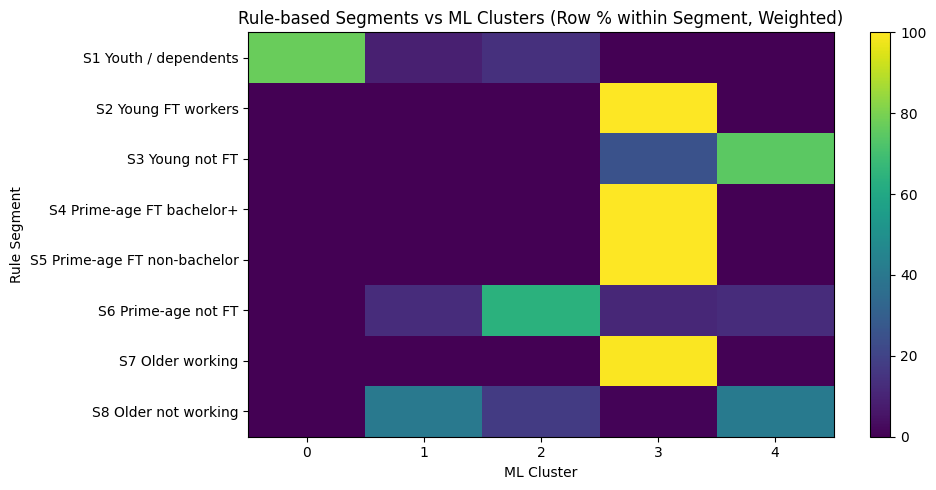

In [ ]:
ct = pd.crosstab(df['segment_rule'], df['cluster_ml'], values=df['weight'], aggfunc='sum').fillna(0)
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100  # row-normalize

plt.figure(figsize=(10,5))
im = plt.imshow(ct_pct.values, aspect='auto', interpolation='nearest')
plt.colorbar(im)

plt.yticks(range(ct_pct.shape[0]), ct_pct.index)
plt.xticks(range(ct_pct.shape[1]), ct_pct.columns.astype(str))
plt.title('Rule-based Segments vs ML Clusters (Row % within Segment, Weighted)')
plt.xlabel('ML Cluster')
plt.ylabel('Rule Segment')
plt.tight_layout()
plt.show()
